In [1]:
import pandas as pd
import numpy as np

from sktime.utils.plotting import plot_series

In [2]:
df_treated = pd.read_csv('data/df_treated.csv').set_index('date')
df_treated.index = pd.to_datetime(df_treated.index)

In [3]:
numeric_col = ['Building0', 'Building1', 'Building3', 'Building4', 'Building5',
                   'Building6', 'Solar0', 'Solar1', 'Solar2', 'Solar3', 'Solar4', 'Solar5',
                   'temperature', 'dewpoint_temperature', 'wind_speed',
                   'mean_sea_level_pressure', 'relative_humidity_01',
                   'surface_solar_radiation', 'surface_thermal_radiation',
                   'total_cloud_cover']
df_treated[numeric_col] = df_treated[numeric_col].apply(pd.to_numeric)
df_numerics = df_treated[numeric_col]

categorical_col = ['COVID', 'Break', 'Semester', 'Exams', 'Monash_occupancy',
               'month', 'day', 'hour']
df_treated[categorical_col] = df_treated[categorical_col].astype('category')
df_categorical = df_treated[categorical_col]

In [4]:
df_hour = df_treated.resample('H').last()

## Buildings

### freq = 1H

In [5]:
# Selección train-test
print(9696 * 0.10) # 1 mes y 10 dias aprox
df_hour['Building0'].iloc[-969:]

969.6


date
2020-09-21 15:00:00    154.6
2020-09-21 16:00:00    155.0
2020-09-21 17:00:00    158.0
2020-09-21 18:00:00    150.9
2020-09-21 19:00:00    154.0
                       ...  
2020-10-31 19:00:00    141.4
2020-10-31 20:00:00    138.5
2020-10-31 21:00:00    123.0
2020-10-31 22:00:00    105.0
2020-10-31 23:00:00     77.6
Freq: H, Name: Building0, Length: 969, dtype: float64

In [6]:
y_train = df_hour['Building0'][:'2020-09-21 14:00:00']
y_test = df_hour['Building0']['2020-09-21 15:00:00':]

print(y_train.shape, y_test.shape)
y_train.shape[0] + y_test.shape[0]

(8727,) (969,)


9696

### Naive seasonal

In [7]:
from sktime.forecasting.naive import NaiveForecaster

fh_naive = np.arange(1, 970)
forecaster = NaiveForecaster(strategy='last', sp=24)

In [8]:
forecaster.fit(y_train)

NaiveForecaster(sp=24)

In [9]:
y_pred = forecaster.predict(fh_naive)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Building0'>)

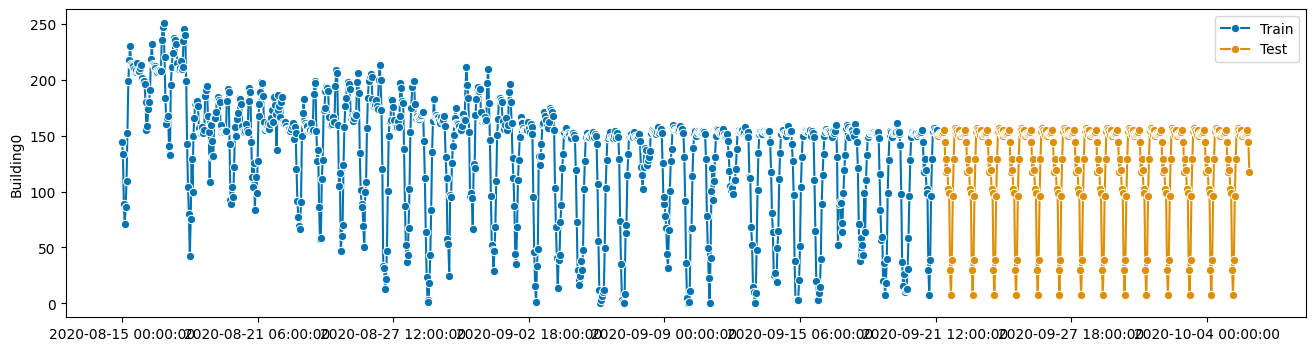

In [10]:
plot_series(y_train['2020-08-15':], y_pred[:'2020-10-05'], labels=['Train', 'Test'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Building0'>)

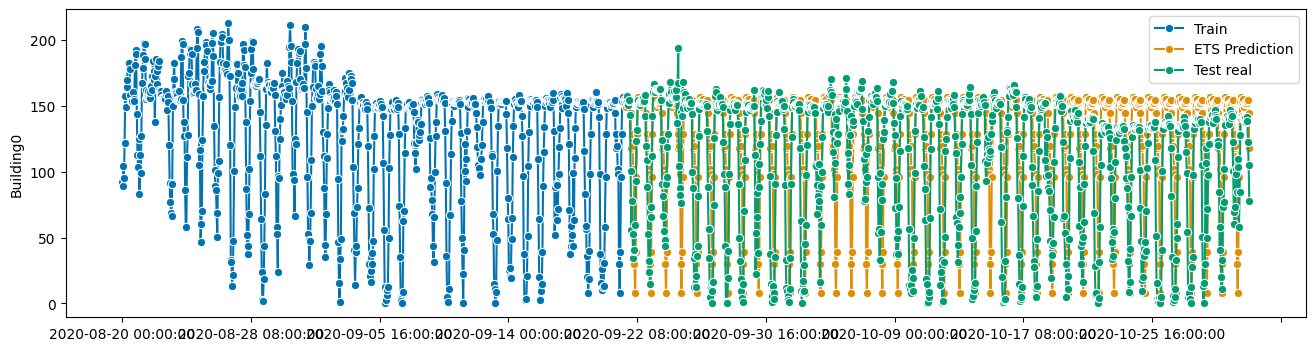

In [11]:
plot_series(y_train['2020-08-20':], y_pred, y_test, labels=["Train", "ETS Prediction", "Test real"])

In [12]:
# Forecast Accuracy
# MAPE

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [13]:
Naive_mape = mean_absolute_percentage_error(y_test, y_pred)
Naive_mape

8.61542465591292

### ETS

In [14]:
from sktime.forecasting.ets import AutoETS

fh = np.arange(1, 970)
autoETS_model = AutoETS(auto=True, sp=24, n_jobs=-1)

In [15]:
autoETS_model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=24)

In [16]:
#  Auto ETS Model Summary
print(autoETS_model.summary())

                                 ETS Results                                  
Dep. Variable:              Building0   No. Observations:                 8727
Model:                       ETS(ANA)   Log Likelihood              -40018.427
Date:                Thu, 01 Sep 2022   AIC                          80092.853
Time:                        15:57:44   BIC                          80290.930
Sample:                    09-24-2019   HQIC                         80160.358
                         - 09-21-2020   Scale                          563.011
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.7490      0.010     71.381      0.000       0.728       0.770
smoothing_seasonal      0.2509      0.004     62.489      0.000       0.243       0.259
initial_level   

In [17]:
#  Auto ETS Forecasting
ETS_pred = autoETS_model.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Building0'>)

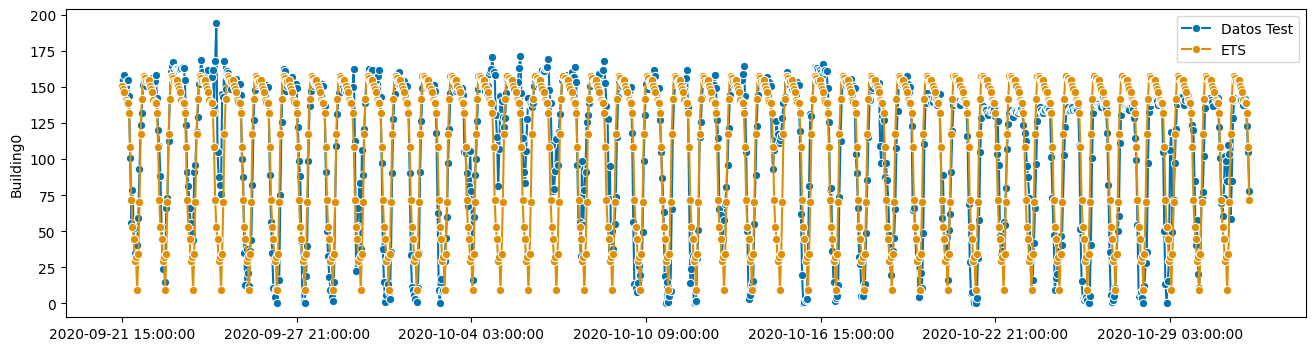

In [18]:
plot_series(y_test, ETS_pred, labels=[ "Datos Test", "ETS"])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Building0'>)

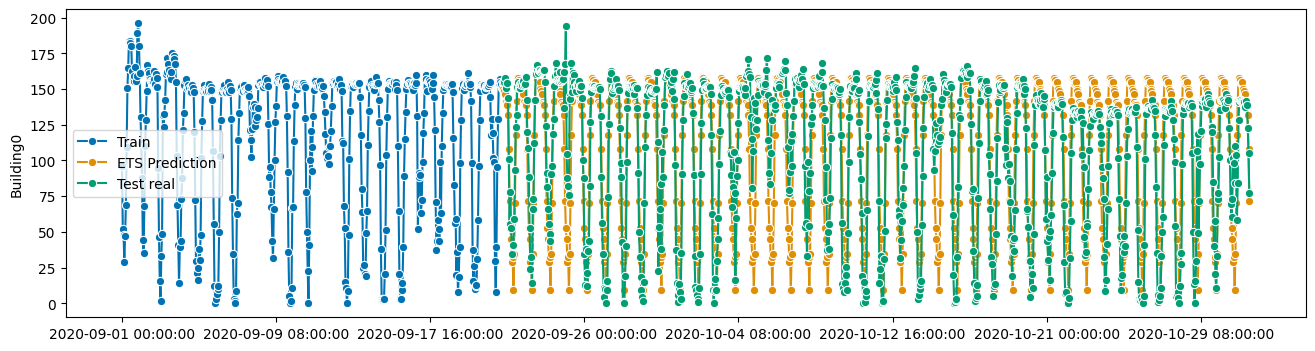

In [19]:
plot_series(y_train['2020-09-01':], ETS_pred, y_test, labels=["Train", "ETS Prediction", "Test real"])

In [20]:
# Forecast Accuracy
# MAPE
ETS_mape = mean_absolute_percentage_error(y_test, ETS_pred)
ETS_mape

3.1627696134771925

In [21]:
# Forecast Accuracy
# Mean Squared Error
rmse = MeanSquaredError(square_root=True)
ETS_rmse = rmse(y_test, ETS_pred)
ETS_rmse

/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


27.739098578563436

In [22]:
df_hour['Solar0']['2020-05-21 05:00:00':]

date
2020-05-21 05:00:00     1.89
2020-05-21 06:00:00     0.25
2020-05-21 07:00:00     0.01
2020-05-21 08:00:00     0.01
2020-05-21 09:00:00     0.01
                       ...  
2020-10-31 19:00:00     0.95
2020-10-31 20:00:00     3.91
2020-10-31 21:00:00     8.00
2020-10-31 22:00:00    18.53
2020-10-31 23:00:00    28.23
Freq: H, Name: Solar0, Length: 3931, dtype: float64

## Solar panels

In [39]:
# Selección train-test
print(3931 * 0.10) # 1 mes y 10 dias aprox
df_hour['Solar0'].iloc[-393:]

393.1


date
2020-10-15 15:00:00     0.01
2020-10-15 16:00:00     0.01
2020-10-15 17:00:00     0.01
2020-10-15 18:00:00     0.01
2020-10-15 19:00:00     1.90
                       ...  
2020-10-31 19:00:00     0.95
2020-10-31 20:00:00     3.91
2020-10-31 21:00:00     8.00
2020-10-31 22:00:00    18.53
2020-10-31 23:00:00    28.23
Freq: H, Name: Solar0, Length: 393, dtype: float64

In [24]:
y_train = df_hour['Solar0']['2020-05-21 05:00:00':'2020-10-15 14:00:00']
y_test = df_hour['Solar0']['2020-10-15 15:00:00':]

print(y_train.shape, y_test.shape)
y_train.shape[0] + y_test.shape[0]

(3538,) (393,)


3931

### Naive

In [25]:
from sktime.forecasting.naive import NaiveForecaster

fh_naive = np.arange(1, 394)
forecaster = NaiveForecaster(strategy='last', sp=24*2)

In [26]:
forecaster.fit(y_train)

NaiveForecaster(sp=48)

In [27]:
y_pred = forecaster.predict(fh_naive)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Solar0'>)

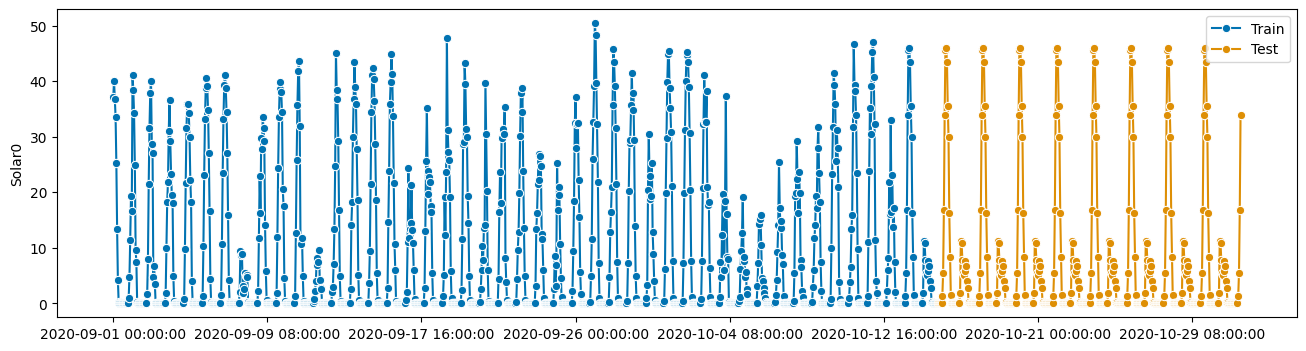

In [28]:
plot_series(y_train['2020-09-01':], y_pred, labels=['Train', 'Test'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Solar0'>)

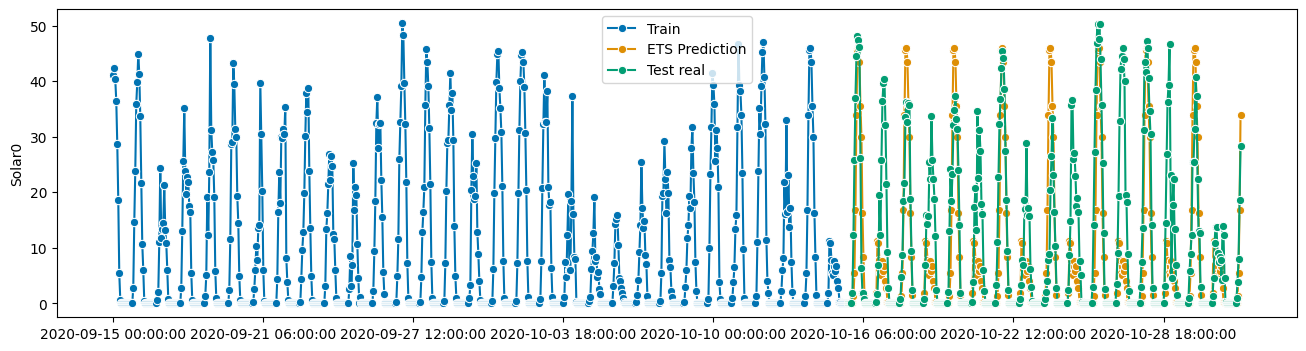

In [29]:
plot_series(y_train['2020-09-15':], y_pred, y_test, labels=["Train", "ETS Prediction", "Test real"])

In [30]:
Naive_mape = mean_absolute_percentage_error(y_test, y_pred)
Naive_mape

0.43192533437053215

### ETS

In [31]:
from sktime.forecasting.ets import AutoETS

fh = np.arange(1, 394)
autoETS_model = AutoETS(auto=True, sp=24*2, n_jobs=-1)

In [32]:
autoETS_model.fit(y_train)

/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

AutoETS(auto=True, n_jobs=-1, sp=48)

In [33]:
#  Auto ETS Forecasting
ETS_pred = autoETS_model.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Solar0'>)

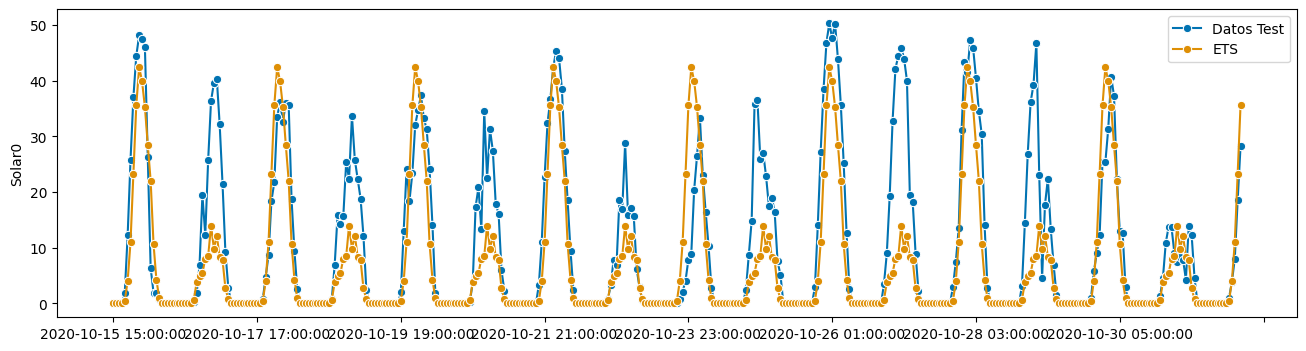

In [34]:
plot_series(y_test, ETS_pred, labels=[ "Datos Test", "ETS"])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Solar0'>)

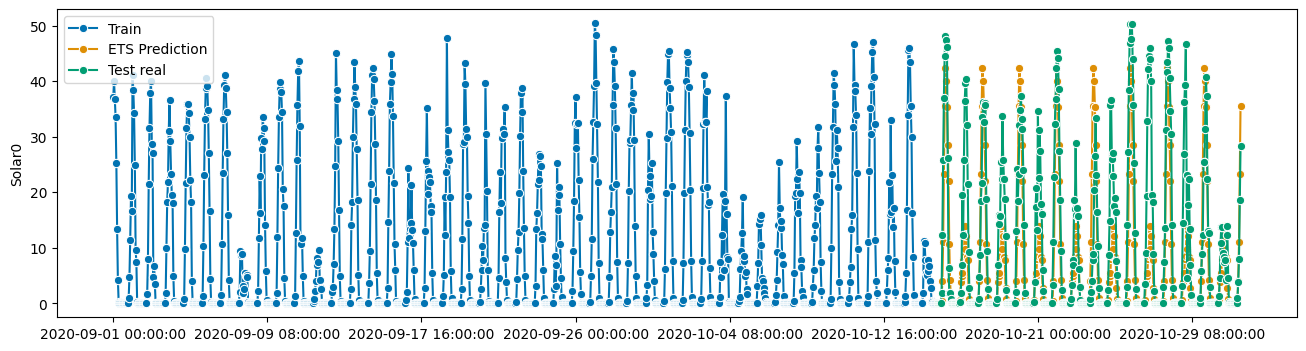

In [35]:
plot_series(y_train['2020-09-01':], ETS_pred, y_test, labels=["Train", "ETS Prediction", "Test real"])

In [36]:
# Forecast Accuracy
# MAPE
ETS_mape = mean_absolute_percentage_error(y_test, ETS_pred)
ETS_mape

0.4386073400212502

In [37]:
# Forecast Accuracy
# Mean Squared Error
rmse = MeanSquaredError(square_root=True)
ETS_rmse = rmse(y_test, ETS_pred)
ETS_rmse

/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


9.035259985129818